# Image Classification với tập dữ liệu CIFAR-10
Notebook này sẽ thực hiện việc phân lớp ảnh từ [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  Tập dữ liệu bao gồm ảnh của các đối tượng: airplanes, dogs, cats, and other objects. Bước đầu tiên là tiền sử lý ảnh, sau đó huấn luyện một mạng convolutional neural network trên tập dữ liệu. Dữ liệu ảnh cần được normalized và labels được encoded dạng one-hot vector. Một vài tập dữ liệu khác để thực hành có thể download tại [đây](http://rodrigob.github.io/are_we_there_yet/build/#datasets)


## Thu thập dữ liệu
Chạy mã trong cell dưới đây để tải về CIFAR-10 tại [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

#### Tham khảo:
- [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html): Tập dữ liệu gồm 80 triệu ảnh kích thước nhỏ đã được gán nhãn. 
- [urlretrieve lib](https://docs.python.org/3.0/library/urllib.request.html): Thư viện thực hiện sao chép một đối tượng từ internet thông qua url về máy tính nếu đối tượng đó chưa tồn tại trên bộ nhớ
- [tarfile lib](https://docs.python.org/2/library/tarfile.html): Đọc và ghi file nén dạng tar, gzip, bz2.
- [tqdm lib](https://pypi.python.org/pypi/tqdm): Tạo thanh Progress

In [1]:
# cài đặt thư viện tqdm
!pip install tqdm

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    Kiểm tra xem file dữ liệu (zip) được tải về chưa
    nếu chưa, tải về tại "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" với tên cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Một số nội dung trước khi bắt đầu với CIFAR-10

### Tham khảo:
- [python pickle](https://docs.python.org/3/library/pickle.html): Thư viện cài đặt các phương thức serializing and de-serializing cho các đối tượng Python, ghi xuống thành file nhị phân.
- [numpy reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html): Thay đổi shape của một mảng numpy mà không làm thay đổi dữ liệu.
- [numpy transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html): Hoán đổi chiều của mảng numpy.
- [Giải thích numpy transpose với mảng nhiều chiều](https://stackoverflow.com/questions/32034237/how-does-numpys-transpose-method-permute-the-axes-of-an-array)
- [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d): Tài liệu về lớp convolution trong tensorflow. Lưu ý đối số mô tả dữ liệu đầu vào "data_format" ("NHWC": [batch, height, width, channels], "NCHW": [batch, channels, height, width]).
- [Giải thích khái niệm row major order](https://en.wikipedia.org/wiki/Row-_and_column-major_order)

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

### Danh sách các files trong CIFAR-10 

![](https://github.com/anhngml/CIFAR10-img-classification-tensorflow/raw/6d33faa5ffc4c48a6553966ad44f15f98d003a34/list_of_batch_files.png)

Như ảnh trên, tập dữ liệu được chia thành nhiều batches nhằm chánh trường hợp máy tính gặp lỗi **out of memory**. CIFAR-10 bao gồm 5 batches, đặt tên `data_batch_1`, `data_batch_2`, etc..


### Tìm hiểu dữ liệu gốc 

Một batch dữ liệu là một tensor (10000 x 3072) chiều dưới dạng numpy array, trong đó con số chỉ số lượng cột, (10000), thể hiện số mẫu dữ liệu. Như đã nêu trong [CIFAR-10/CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), vector hàng, (3072) biểu diễn một ảnh màu 32x32 pixels. Vì notebook này dự định sử dụng CNN cho bài toán phân lớp,vector hàng, (3072), là không phù hợp để làm input đưa vào mạng. Để đưa một dữ liệu ảnh vào mô hình CNN, kích thước của tensor biểu diễn một ảnh cần có dạng (width x height x num_channel) hoặc (num_channel x width x height), phụ thuộc vào lựa chọn định dạng dữ liệu đầu vào (xem tại [tensorflow conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)). Notebook này lựa chọn định dạng mặc định của tensorflow.


### Nhãn của dữ liệu

Dữ liệu nhãn gồm một list của 10000 số trong khoảng 0-9, tương ứng với một trong 10 lớp trong CIFAR-10. 

* **airplane**
* **automobile**
* **bird**
* **cat**
* **deer**
* **dog**
* **frog**
* **horse**
* **ship**
* **truck**


In [4]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Reshape về kích thước phù hợp cho CNN

Vector hàng (3072) có cùng số lượng phần tử với ảnh màu 32\*32\*3==3072. Để reshape vector hàng, (3072), cần thực hiện 2 bước. Bước **đầu tiên** là sử dụng hàm **reshape** của numpy, và bước **thứ hai** sử dụng hàm **transpose** cũng của numpy.

Theo định nghĩa, hàm **reshape** thay đổi shape của một mảng mà không làm thay đổi dữ liệu. **Reshape** Có thể chia thành các bước chi tiết dưới đây: 

1. Chia vector hàng (3072) thành 3 phần. Mỗi phần tương ứng với một kênh màu.
  - kết quả là tensor với kích thước (3 x 1024)
2. Chia tensor thu được từ bước 1 thành 32. 32 ở đây chính là kích thước chiều rộng của anh.
  - kết quả là tensor (3 x 32 x 32)

Đối số cho hàm **reshape** sẽ là một tuple, (10000, 3, 32, 32).

Chưa xong, bây giờ tập dữ liệu ảnh được biểu diễn dạng (num_channel, width, height). Tuy nhiên, **đây không phải là shape mà tensorflow và matplotlib mong đợi**, mà là (width, height, num_channel). Vậy cần phải hoán đổi thứ tự của mỗi trục, bằng cách sử dụng hàm **transpose**.

<img src="https://github.com/anhngml/CIFAR10-img-classification-tensorflow/raw/6d33faa5ffc4c48a6553966ad44f15f98d003a34/reshape-transpose.png" alt="Drawing" style="width: 800px;"/>

In [5]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

## Khám phá dữ liệu

Hiểu tập dữ liệu là một phần quan trọng trong xây dựng hệ thống prediction trên dữ liệu. Thử nghiệm đoạn code sau và thử thay đổi tham số `batch_id` và `sample_id`. `batch_id` là id của mỗi batch (1-5). `sample_id` là id của một cặp sample - label trong batch.

Hàm display_stats cho biết các thông tin của từng batch:
- "Có những nhãn nào tất cả?"
- "Miền giá trị của mỗi dữ liệu ảnh?"
- "Các nhãn là tuần tự hay ngẫu nhiên?"


In [6]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7000:
Image - Min Value: 24 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 0 Name: airplane


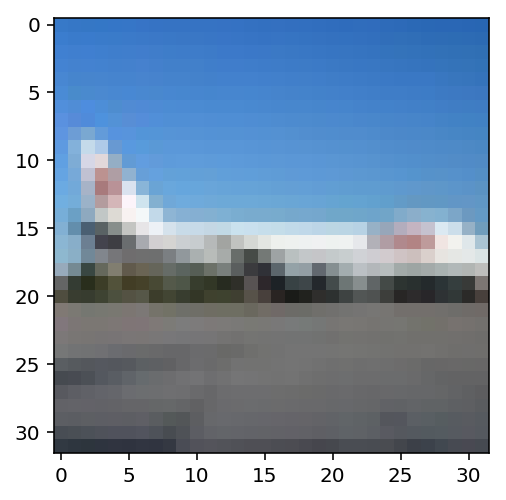

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3
sample_id = 7000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Cài đặt hàm tiền xử lý dữ liệu
### Normalize
**Min-Max Normalization**
- phương pháp này đơn giản chỉ thực hiện việc đưa giá trị của x về khoảng giữa 0 và 1.
- y = (x-min) / (max-min)

**Tham khảo**
- [Min-Max Normalization](https://www.quora.com/What-is-the-meaning-of-min-max-normalization)
- [Xem "tại sao phải normalizing inputs" / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=FDCfw-YqWTE)
- [Exploding, Vainishing Gradient descent / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=qhXZsFVxGKo)

Hàm `normalize` nhận một ảnh, `x`, và trả về một mảng Numpy đã normalized. Giá trị ban đầu của dữ liệu được biến đổi về khoảng 0 đến 1, nhưng không làm thay đổi kích thước, hình dạng mảng. Câu trả lời đơn giản cho tại sao cần normalization liên quan đến hàm kích hoạt.

Ví dụ, hàm sigmoid activation nhận giá trị vào và trả ra giá trị mới trong khoảng 0 đến 1. Khi giá trị đầu vào lớn, giá trị trả ra tiến gần đến 1. Tương tự, khi giá trị đầu vào nhỏ, đầu ra gần đến 0. 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/480px-Logistic-curve.svg.png" alt="Drawing" style="width: 300px;"/>

Một ví dụ khác, hàm kích hoạt ReLU nhận giá trị đầu vào và đưa ra giá trị mới trong khoảng từ 0 đến dương vô cùng. Khi đầu vào lớn, giá trị đầu ra tăng một cách tuyến tính. Tuy nhiên, khi đầu vào nhỏ, giá trị trả về tiến đến 0. 

<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_4/Relu.jpeg" alt="Drawing" style="width: 300px;"/>

bây giờ, xem xét dữ liệu ảnh, mọi giá trị ban đầu thuộc khoảng 0 đến 255. Khi ảnh chuyền qua hàm sigmoid, giá trị gần như luôn luôn gần với 1, và khi chuyền qua ReLu, giá trị trả ra luôn rất lớn. Khi thực hiện lan truyền ngược để tối ưu mạng, dễ dẫn đến bùng nổ gradient dẫn đến bước cập nhật trọng số "kinh khủng". Để tránh vấn đề kể trên, tốt nhất là nên đưa giá trị về khoảng 0 và 1.

In [8]:
def normalize(x):
    """
        argument
            - x: input image data in numpy array [32, 32, 3]
        return
            - normalized x 
    """
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

### One-hot encode

Vì output của mô hình thể hiện xác suất một ảnh thuộc vào từng lớp, nên nó cần ở dạng một vector có số thành phần bằng với số lớp. Cụ thể, CIFAR-10 có 10 lớp đối tượng khác nhau của ảnh, vậy cần vector có kích thước cũng là 10. Mỗi thành phần của vector thể hiện kết quả dự đoán là xác suất thuộc về mỗi lớp.

Mô hình cần so sánh dự đoán đầu ra với nhãn đúng. Nghĩa là hình dạng của nhãn cũng cần phải biến đổi thành một vector kích thước bằng 10. Bởi vì nhãn là ground truth, chúng ta đặt giá trị 1 cho thành phần tương ứng với nhãn của vector.

**`one_hot_encode`** nhận đầu vào, **`x`**, là một list các nhãn (ground truth). Tổng số thành phần của list là tổng số samples trong một batch. **`one_hot_encode`** trả về một tensor kích thước bằng 2, với số dòng là kích thước batch, tổng số cột là số lớp của ảnh.

#### Tham khảo
- [one hot encoding](https://www.quora.com/What-is-one-hot-encoding-and-when-is-it-used-in-data-science)

In [9]:
def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))
    
    for idx, val in enumerate(x):
        encoded[idx][val] = 1
    
    return encoded

## Tiền xử lý dữ liệu

Đoạn code dưới đây dùng hàm đã cài đặt phía trên, normalize and one_hot_encode, để tiến hành tiền xử lý toàn bộ tập dữ liệu.
Chạy cell bên dưới sẽ thực hiện tiền xử lý toàn bộ tập CIFAR-10 và lưu xuống file, đồng thời phân chia 10% dữ liệu huấn luyện cho validation. 

<img src="https://github.com/anhngml/CIFAR10-img-classification-tensorflow/raw/6d33faa5ffc4c48a6553966ad44f15f98d003a34/train-valid-test%20split.png" alt="Drawing" style="width: 700px;"/>

In [10]:
def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        
        # find index to be the point as validation data in the whole dataset of the batch (10%)
        index_of_validation = int(len(features) * 0.1)

        # preprocess the 90% of the whole dataset of the batch
        # - normalize the features
        # - one_hot_encode the lables
        # - save in a new file named, "preprocess_batch_" + batch_number
        # - each file for each batch
        _preprocess_and_save(normalize, one_hot_encode,
                             features[:-index_of_validation], labels[:-index_of_validation], 
                             'preprocess_batch_' + str(batch_i) + '.p')

        # unlike the training dataset, validation dataset will be added through all batch dataset
        # - take 10% of the whold dataset of the batch
        # - add them into a list of
        #   - valid_features
        #   - valid_labels
        valid_features.extend(features[-index_of_validation:])
        valid_labels.extend(labels[-index_of_validation:])

    # preprocess the all stacked validation dataset
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(valid_features), np.array(valid_labels),
                         'preprocess_validation.p')

    # load the test dataset
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # preprocess the testing data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all testing data
    _preprocess_and_save(normalize, one_hot_encode,
                         np.array(test_features), np.array(test_labels),
                         'preprocess_training.p')

In [11]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

## Checkpoint


In [12]:
import pickle

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

### Tạo mô hình Convolutional

Toàn bộ mô hình bao gồm 14 layers.

1. Convolution với 64 filters kích thước (3x3)
2. Max Pooling với
  - ReLU activation function 
  - Batch Normalization
3. Convolution với 128 filters kích thước (3x3)
4. Max Pooling với
  - ReLU activation function 
  - Batch Normalization
5. Convolution với 256 filters kích thước (3x3)
6. Max Pooling với
  - ReLU activation function 
  - Batch Normalization
7. Convolution với 512 filters kích thước (3x3)
8. Max Pooling với
  - ReLU activation function 
  - Batch Normalization
9. Flattening (duỗi phẳng) 3-D output của lớp convolutional cuối cùng.
10. Fully Connected Layer với 128 units
  - Dropout 
  - Batch Normalization
11. Fully Connected Layer với 256 units
  - Dropout 
  - Batch Normalization
12. Fully Connected Layer với 512 units
  - Dropout 
  - Batch Normalization
13. Fully Connected Layer với 1024 units
  - Dropout 
  - Batch Normalization
14. Fully Connected Layer với 10 units (tổng số lớp của dữ liệu ảnh)

ảnh dưới đây mô tả phép convolutionđược cài đặt trong tensorflow với tensor có dạng [Channel x Width x Height]. 

<img src="https://github.com/anhngml/CIFAR10-img-classification-tensorflow/raw/6d33faa5ffc4c48a6553966ad44f15f98d003a34/convolving.png" alt="Drawing" style="width: 1000px;"/>

#### tham khảo
- [Tensorflow Conv2D under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
- [Tensorflow ReLU under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/relu)
- [Tensorflow Max Pooling under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/max_pool)
- [Tensorflow Dropout under tf.nn](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)
- [Tensorflow Batch Normalization under tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization)
- [Tensorflow Flatten under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/flatten)
- [Tensorflow Fully Connected under tf.contrib](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/fully_connected)
- [Batch Normalization (the original paper)](https://arxiv.org/abs/1502.03167)
- [Why does Batch Norm works? / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=NbGUU6ZYtus)
- [Dropout (the original paper)](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
- [Understanding Dropout / deeplearning.ai - Andrew Ng.](https://www.youtube.com/watch?v=ARq74QuavAo)
- [Dropout in (Deep) Machine learning](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
- [What is the meaning of flattening step in a convolutional neural network?](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network)
- [Convolutional Neural Networks (CNNs / ConvNets) - CS231n](http://cs231n.github.io/convolutional-networks/)
- [Visualizing and Understanding Convolutional Networks](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf)
- [Evaluation of the CNN design choices performance on ImageNet-2012](https://github.com/ducha-aiki/caffenet-benchmark)

## Lấy dữ liệu từ các file batch

In [13]:
import pickle
import numpy as np

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def load_cfar10_batch(batch_id):
    features, labels = pickle.load(open('preprocess_batch_' + str(batch_id)+'.p', mode='rb'))
    return features, labels

# import data
x_valid, y_valid = pickle.load(open('preprocess_validation.p', mode='rb'))
x_test, y_test = pickle.load(open('preprocess_training.p', mode='rb'))
x_train, y_train = load_cfar10_batch(1)
y_train = np.array(y_train)

for i in np.arange(2, 6):
    x_batch, y_batch = load_cfar10_batch(i)
    x_train = np.concatenate((x_train, x_batch), axis=0)
    y_train = np.concatenate((y_train, np.array(y_batch)), axis=0)

print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)
(10000, 32, 32, 3)


## Build model with Keras

In [14]:
# build model
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(128, kernel_size=(3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Conv2D(256, kernel_size=(3, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(units=128, activation='relu'))
Dropout(0.25)
model.add(Dense(units=256, activation='relu'))
Dropout(0.25)
model.add(Dense(units=512, activation='relu'))
Dropout(0.25)
model.add(Dense(units=1024, activation='relu'))
Dropout(0.25)
model.add(Dense(units=10, activation='softmax'))

from keras.optimizers import SGD
# Compile model
epochs = 25
lr = 0.001
decay = lr/epochs
sgd = SGD(lr=lr, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

Using TensorFlow backend.


## Train model

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=epochs
          , validation_data=(x_valid, y_valid))

## Lưu model với Json

In [ ]:
# save model as json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

## Kiểm thử model đã lưu

In [21]:
from keras.models import model_from_json

# load model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights("model.h5")
print("loaded model from disk")

loaded model from disk


In [31]:
# load test data
X, Y = pickle.load(open('preprocess_training.p', mode='rb'))
loaded_model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y)

10000/10000 [==============================] - ETA: 43 - ETA: 21 - ETA: 17 - ETA: 15 - ETA: 14 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ET

In [33]:
#accuracy
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 69.63%


## Dự đoán mô hình

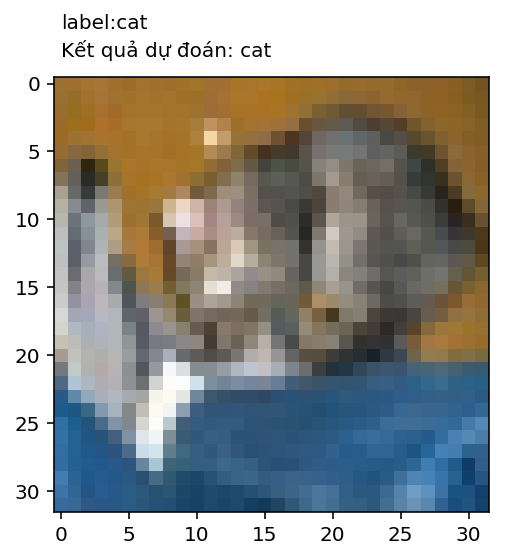

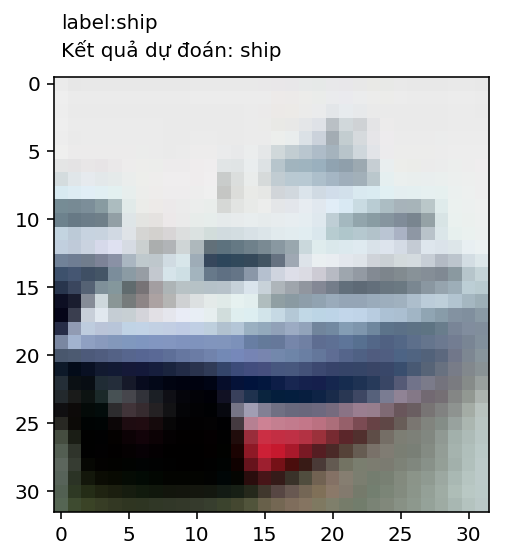

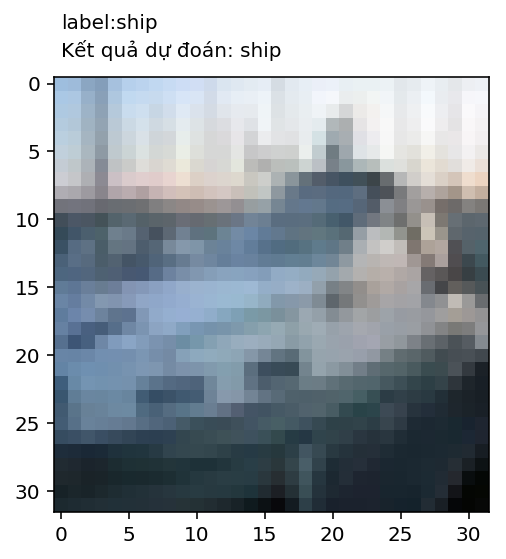

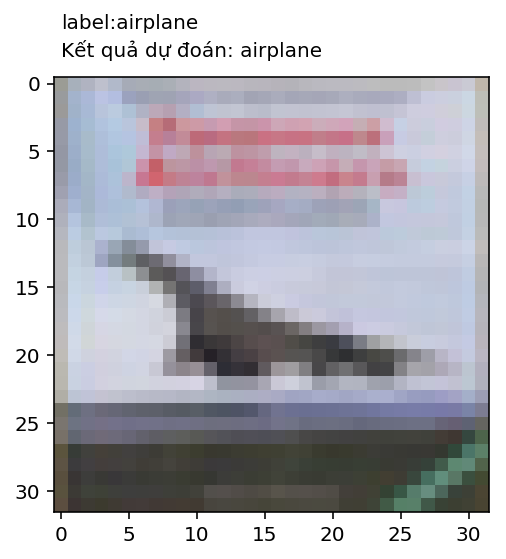

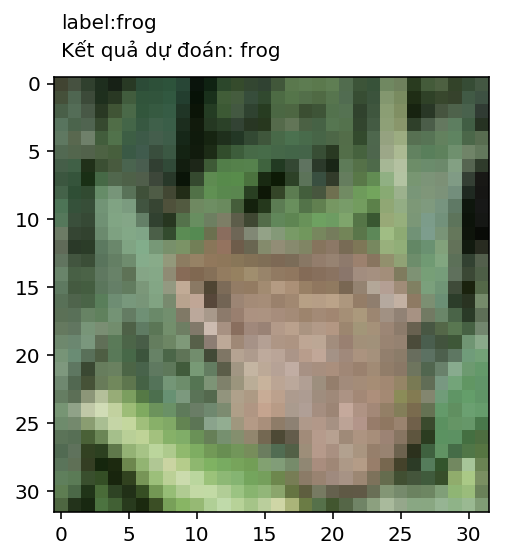

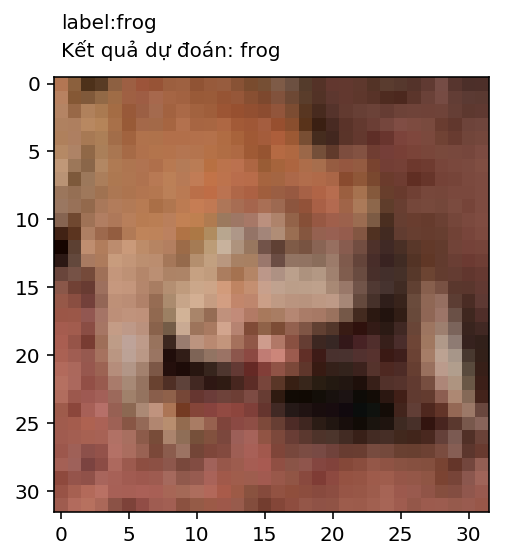

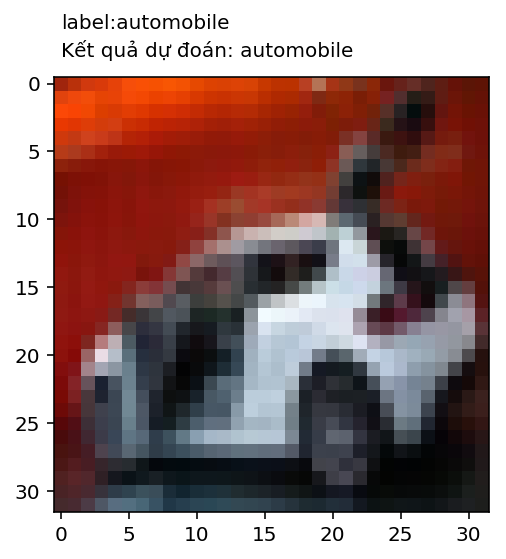

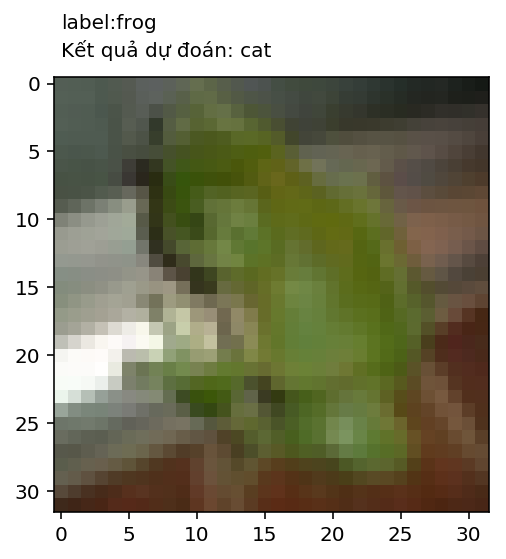

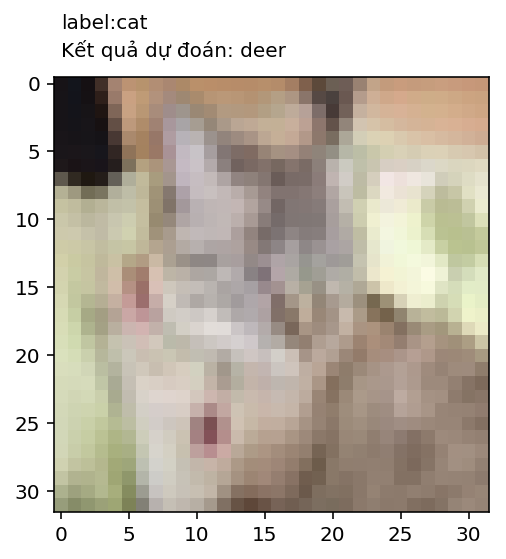

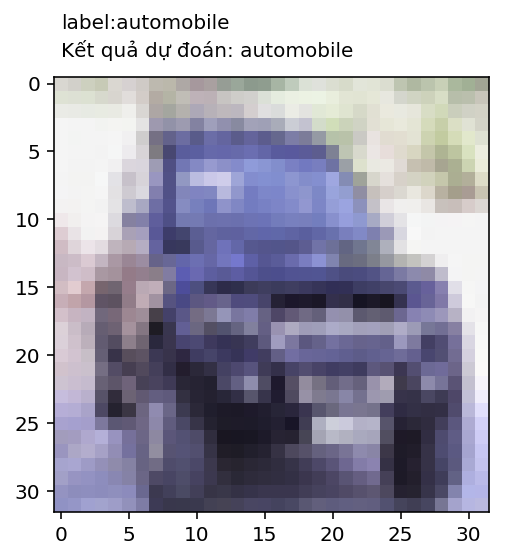

In [34]:
import matplotlib.pyplot as plt
classes = loaded_model.predict(X, batch_size=128)
preds = np.argmax(classes, axis=1)

for i in range(10):
    plt.imshow(X[i])
    predict = "Kết quả dự đoán: " + str(load_label_names()[preds[i]])
    output = "label:"+ str(load_label_names()[np.argmax(Y[i])])
    plt.text(0, -2, predict)
    plt.text(0, -4, output)
    plt.show()